# Modeling of duration esitmation under memory load

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_sM$$

$$\sigma_{wm}^2 = \sigma_s^2 + l_s\cdot \log(M+T_g)$$

where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os



In [2]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2024-10-01 14:55:03.155051


In [3]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllValidData.csv')
# additional experiment 6 : Exp6.csv
exp6 = pd.read_csv(cpath + '/data/Exp6.csv')

# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()



,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,WMRP,valid,stdRepDur,Exp,gap,log_RP,log_dur,Gap,ExpName
0,3,1,1,1,1,0.5,0.742038,2,1,0.203701,Exp1,1,-0.298354,-0.693147,0.5,Baseline
1,3,4,1,2,1,1.4,1.301903,1,1,0.297183,Exp1,1,0.263827,0.336472,0.5,Baseline
2,3,3,1,3,1,1.1,0.805957,1,1,0.201791,Exp1,1,-0.215724,0.095310,0.5,Baseline
3,3,5,2,4,1,1.7,1.253941,2,1,0.168043,Exp1,1,0.226292,0.530628,0.5,Baseline
4,3,4,2,5,1,1.4,0.709891,2,1,0.297183,Exp1,1,-0.342644,0.336472,0.5,Baseline


In [4]:
expData.ExpName.unique()

array(['Baseline', 'Encoding', 'Reproduction', 'Both', 'Both_gap'],
      dtype=object)

In [14]:
# find out the unique gap from ExpName Both_gap
expData[expData['ExpName'] == 'Both_gap']['gap'].unique()

array([2, 1])

In [89]:
# define PYMC partial pooling model
trace = 0
def hModel(dat, constrain):
	# prepare the data
    subid = dat.NSub - 1 # starting from index 0
    nsub = len(dat.NSub.unique())  # number of subject
    # log-transformed working memory size
    wm_idx = np.log(dat.WMSize.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    #lnRep = dat.log_RP # log-transformed reproduction
    lnDur = np.log(durs)
    #wm_sig_gap = np.log(dat.WMSize.to_numpy() + dat.gap.to_numpy()-1) # only for the gap manipulation

    niter = 1000
    # define model
    with pm.Model() as WMmodel:
        # sensory measurement
        sig_s = pm.HalfNormal('sig_s',1., shape = nsub) # noise of the sensory measurement
        # auxiliary variables (non-centered parameterization, individual level)
        epsilon = pm.HalfNormal('epsilon', 1, shape = nsub)
        if constrain[0] == 1:
            k_s0 = pm.HalfNormal('k_s',1) # working memory coeff. on ticks
            k_s = epsilon * k_s0
        else:
            k_s = np.zeros(nsub)
        if constrain[1] == 1:
            l_s0 = pm.HalfNormal('l_s',1) # working memory impacts on variance
            l_s = epsilon * l_s0
        else:
            l_s = np.zeros(nsub)
        if constrain[2] == 1:
            wm_sig = np.log(dat.WMSize.to_numpy() + dat.gap.to_numpy()-1) # only for the gap manipulation 
        else:
            wm_sig = np.log(dat.WMSize.to_numpy())
                  
        if constrain[3] == 1:
            k_r0 = pm.Normal('k_r', 0, sigma = 1) # working memory influence on reproduction 
            k_r = epsilon * k_r0
            #k_r = pm.HalfNormal('k_r', 1, shape = nsub)
        else:
            k_r = np.zeros(nsub) 

        # prior (internal log encoding)
        mu_p = pm.Normal('mu_p', 0, sigma = 1, shape = nsub) # in log space
        sig_p = pm.HalfNormal('sig_p', 1, shape = nsub) # in log-space
        #mu_p = mu_p0 + sig_p[subid] * epsilon

        sig_n0 = pm.HalfNormal('sig_n', 1) #pm.Bound( pm.HalfNormal, lower = 0.15)('sig_n', 5.) # constant decision /motor noise
        sig_n = sig_n0 * epsilon
        # sensory measurement with log encoding + ticks loss by memory task
        D_s = lnDur - k_s[subid] * wm_idx
        sig_sm = sig_s[subid] + l_s[subid] * wm_sig # variance influenced by memory tasks
        # integration with prior
        w_p = sig_sm*sig_sm / (sig_p[subid]*sig_p[subid] + sig_sm*sig_sm)
        # posterior
        u_x = (1-w_p)*D_s + w_p * mu_p[subid] # posterior mean
        sig_x2 = sig_sm*sig_sm*sig_p[subid]*sig_p[subid]/(sig_sm*sig_sm + sig_p[subid]*sig_p[subid])
        # reproduction
        # reproduced duration
        u_r = np.exp(u_x + k_r[subid] * wm_idx + sig_x2/2) # reproduced duration with corrupted from memory task
        #reproduced sigmas
        sig_r = np.sqrt((np.exp(sig_x2)-1)*np.exp(2*(u_x + k_r[subid] * wm_idx) +sig_x2 )  + 
            sig_n[subid]*sig_n[subid] /durs)

        # Data likelihood 
        resp_like = pm.Normal('resp_like', mu = u_r, sigma = sig_r, observed = repDur)

        trace = pm.sample(draws=2000, tune = 1000, progressbar=True, return_inferencedata=True, target_accept=0.85)
                  
    #step = pm.Metropolis() # Have a choice of samplers
    #trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    return  trace, WMmodel	


# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	for i in range(nsub):
		for j in range(nDur):
			for k in range(nWM):
				subid = i
				curDur = dat.curDur.unique()[j]
				WMSize = dat.WMSize.unique()[k]
				idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize)
				if np.sum(idx) > 0:
					mPred = np.mean(posterior_samples[:, idx])
					sdPred = np.std(posterior_samples[:, idx])
					df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
					# concatenate the dataframe
					posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# define a function to plot oberved and predicted data (bias, CV, and scatter plot)
def plotModelPred(mdat, figname='model_pred.png'):
	# Ensure WMSize is treated as a categorical variable
	mdat['WMSize'] = mdat['WMSize'].astype('category')
	mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
										'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
	mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

	# Create a figure and axes with three subplots
	fig, ax = plt.subplots(1, 3, figsize=(12, 4))
	# Set a white background with a more scientific style
	sns.set_theme(style="white", context="paper")
	# Plot the bias (fig_bias) on the left axis (ax[0])
	sns.lineplot(
		data=mmdat, x='curDur', y='predErr_mean', hue='WMSize', 
		ax=ax[0]
	)
	sns.scatterplot(
		data=mmdat, x='curDur', y='repErr_mean', hue='WMSize', 
		ax=ax[0], legend=False
	)
	ax[0].errorbar(
		mmdat['curDur'], mmdat['repErr_mean'], 
		yerr=mmdat['repErr_sem'], fmt='none', capsize=3, color='gray'
	)
	ax[0].set_title('(a) Bias')
	ax[0].set_xlabel('Duration (s)')
	ax[0].set_ylabel('Rep Error Mean (s)')
	ax[0].legend(title='Memory Load')
	# Plot the CV (fig_cv) on the right axis (ax[1])
	sns.lineplot(
		data=mmdat, x='curDur', y='predCV_mean', hue='WMSize', 
		ax=ax[1]
	)
	sns.scatterplot(
		data=mmdat, x='curDur', y='repCV_mean', hue='WMSize', 
		ax=ax[1], legend=False
	)
	ax[1].errorbar(
		mmdat['curDur'], mmdat['repCV_mean'], 
		yerr=mmdat['repCV_sem'], fmt='none', capsize=3, color='gray'
	)
	ax[1].set_title('(b) CV')
	ax[1].set_xlabel('Duration (s)')
	ax[1].set_ylabel('Mean CV')
	ax[1].legend(title='Memory Load')
	# Plot the scatter plot (fig_scatter) on the right axis (ax[2])
	sns.scatterplot(
		data = mdat, x = 'repErr', y = 'predErr', hue = 'WMSize',
		ax = ax[2])
	ax[2].set_title('(c) Observed vs. Predicted Error')
	ax[2].set_xlabel('Observed Error (s)')
	ax[2].set_ylabel('Predicted Error (s)')
	ax[2].legend(title='Memory Load')
	# Adjust the layout
	plt.tight_layout()
	# save the figure
	plt.savefig(cpath + '/analysis/figures/' + figname)
	# Show the plot
	plt.show()





In [16]:
#define runModel function
def runModel(dat, constrain, model_name):
	# run the model
	trace, model = hModel(dat, constrain)
	with model:
		ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
		posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy() # back to linear scale
		posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2]) # reshape the array
	# get the mean of posterior samples
	mdat = getPosteriorSummary(posterior_samples, dat)

	# summarize the trace
	para = az.summary(trace)

	# save the trace, model, mdat, and summary
	az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')
	mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
	para.to_csv(cpath + '/data/' + model_name +'_para.csv')
	return  trace, model, para, mdat

## Experiments with Memory Load on Encoding


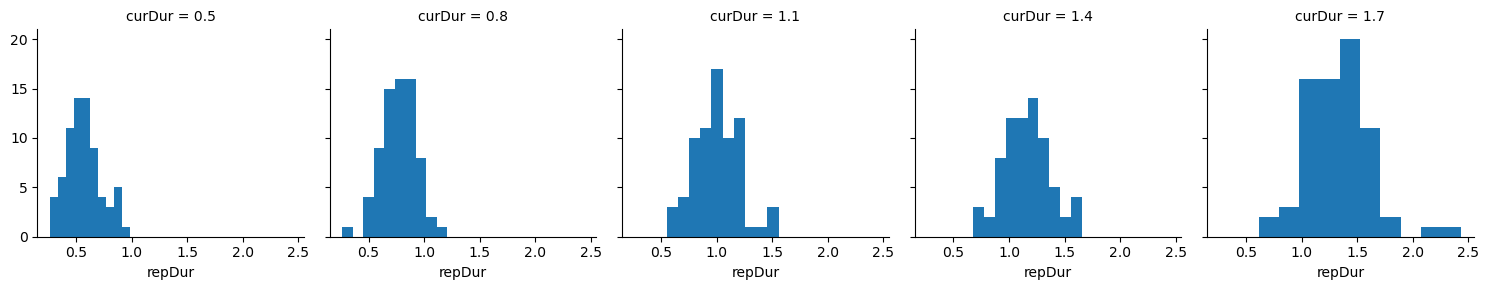

In [17]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
dat_encoding.NSub.unique()
# using seaborn to show histogram of repDur from one subject , facet by curDur

g = sns.FacetGrid(dat_encoding.query('NSub == 15'), col="curDur", col_wrap=5)
g.map(plt.hist, "repDur")
plt.show()

Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

In [81]:
firstrun = True
if firstrun:
	constrain = [1,1,0, 1] # use all scaling parameters
	encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, 'encoding')
	encoding_para
else:
	encoding_trace = az.from_netcdf(cpath + '/data/encoding_trace.nc')
	encoding_mdat = pd.read_csv(cpath + '/data/encoding_mdat.csv')
	encoding_para = pd.read_csv(cpath + '/data/encoding_para.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 162 seconds.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


In [83]:
encoding_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon[0],1.039,0.254,0.605,1.564,0.005,0.003,2582.0,3091.0,1.0
epsilon[1],0.528,0.156,0.246,0.823,0.003,0.002,2699.0,2833.0,1.0
epsilon[2],0.590,0.204,0.212,0.995,0.004,0.003,2950.0,2846.0,1.0
epsilon[3],0.852,0.228,0.465,1.324,0.004,0.003,2912.0,3686.0,1.0
epsilon[4],0.467,0.307,0.000,0.993,0.004,0.003,4516.0,3670.0,1.0
...,...,...,...,...,...,...,...,...,...
sig_s[11],0.403,0.111,0.196,0.599,0.001,0.001,6793.0,4876.0,1.0
sig_s[12],0.343,0.042,0.265,0.418,0.000,0.000,7488.0,4966.0,1.0
sig_s[13],0.276,0.022,0.236,0.317,0.000,0.000,6632.0,4664.0,1.0
sig_s[14],0.184,0.016,0.156,0.216,0.000,0.000,9162.0,6234.0,1.0


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/3870973951.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


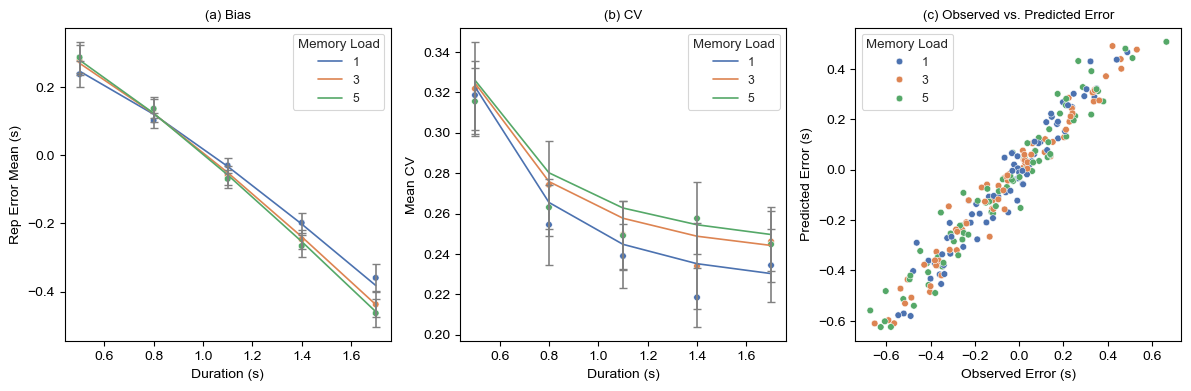

In [22]:
# plot the model prediction
plotModelPred(encoding_mdat, 'encoding')

## Memory Load on Reproduction


In [84]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']
firstrun = True
if firstrun:
	constrain = [1,1,0,1] # scaling factors 
	reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat = runModel(dat_reproduction, constrain, 'reproduction')
	reproduction_para
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/reproduction_para.csv')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 102 seconds.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


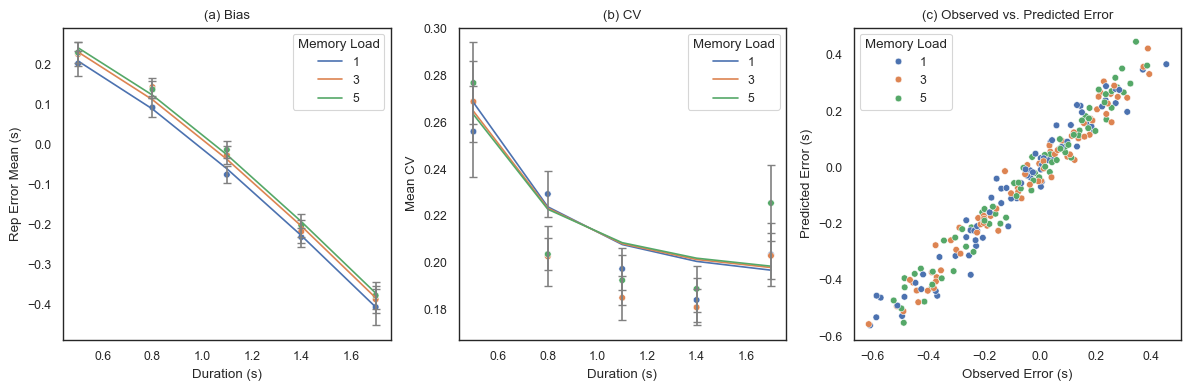

In [85]:
# plot the model prediction
plotModelPred(reproduction_mdat, 'reproduction')

## Baseline Model

In [86]:
dat_baseline = expData[expData['ExpName'] == 'Baseline']
firstrun = True
if firstrun:
	constrain = [1,1,0,1] # scaling factors
	baseline_trace, baseline_model, baseline_para, baseline_mdat = runModel(dat_baseline, constrain, 'baseline')
	baseline_para
else:
	baseline_trace = az.from_netcdf(cpath + '/data/baseline_trace.nc')
	baseline_mdat = pd.read_csv(cpath + '/data/baseline_mdat.csv')
	baseline_para = pd.read_csv(cpath + '/data/baseline_para.csv')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 166 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


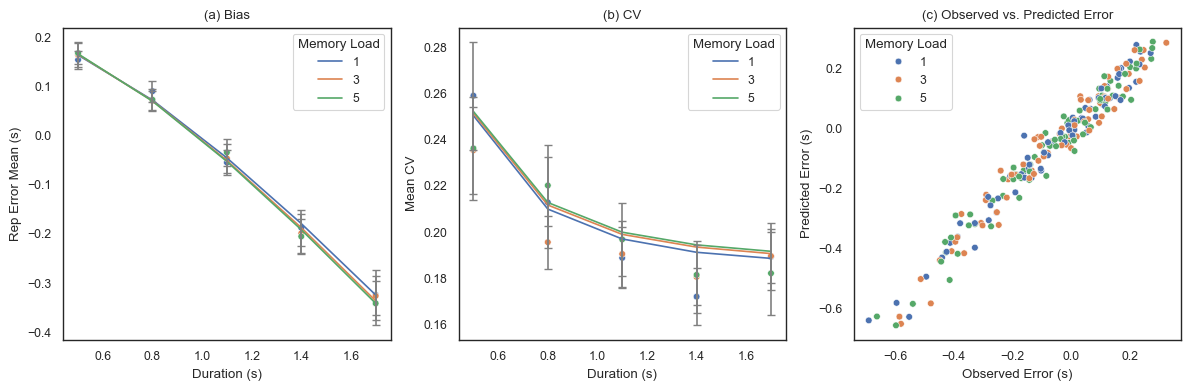

In [87]:
plotModelPred(baseline_mdat, 'baseline')

## Memory Load on Encoding and Reproduction


In [43]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = True
if firstrun:
	constrain = [1,1,0,1] # scaling factor for k_s, l_s, gap, k_r
	both_trace, both_model, both_para, both_mdat = runModel(dat_both, constrain, 'both')
	both_para
else:
	both_trace = az.from_netcdf(cpath + '/data/both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/both_para.csv')



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 198 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


array([[<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>],
       [<Axes: title={'center': 'k_r'}>, <Axes: title={'center': 'k_r'}>],
       [<Axes: title={'center': 'k_s'}>, <Axes: title={'center': 'k_s'}>],
       [<Axes: title={'center': 'l_s'}>, <Axes: title={'center': 'l_s'}>],
       [<Axes: title={'center': 'mu_p'}>,
        <Axes: title={'center': 'mu_p'}>],
       [<Axes: title={'center': 'sig_n'}>,
        <Axes: title={'center': 'sig_n'}>],
       [<Axes: title={'center': 'sig_p'}>,
        <Axes: title={'center': 'sig_p'}>],
       [<Axes: title={'center': 'sig_s'}>,
        <Axes: title={'center': 'sig_s'}>]], dtype=object)

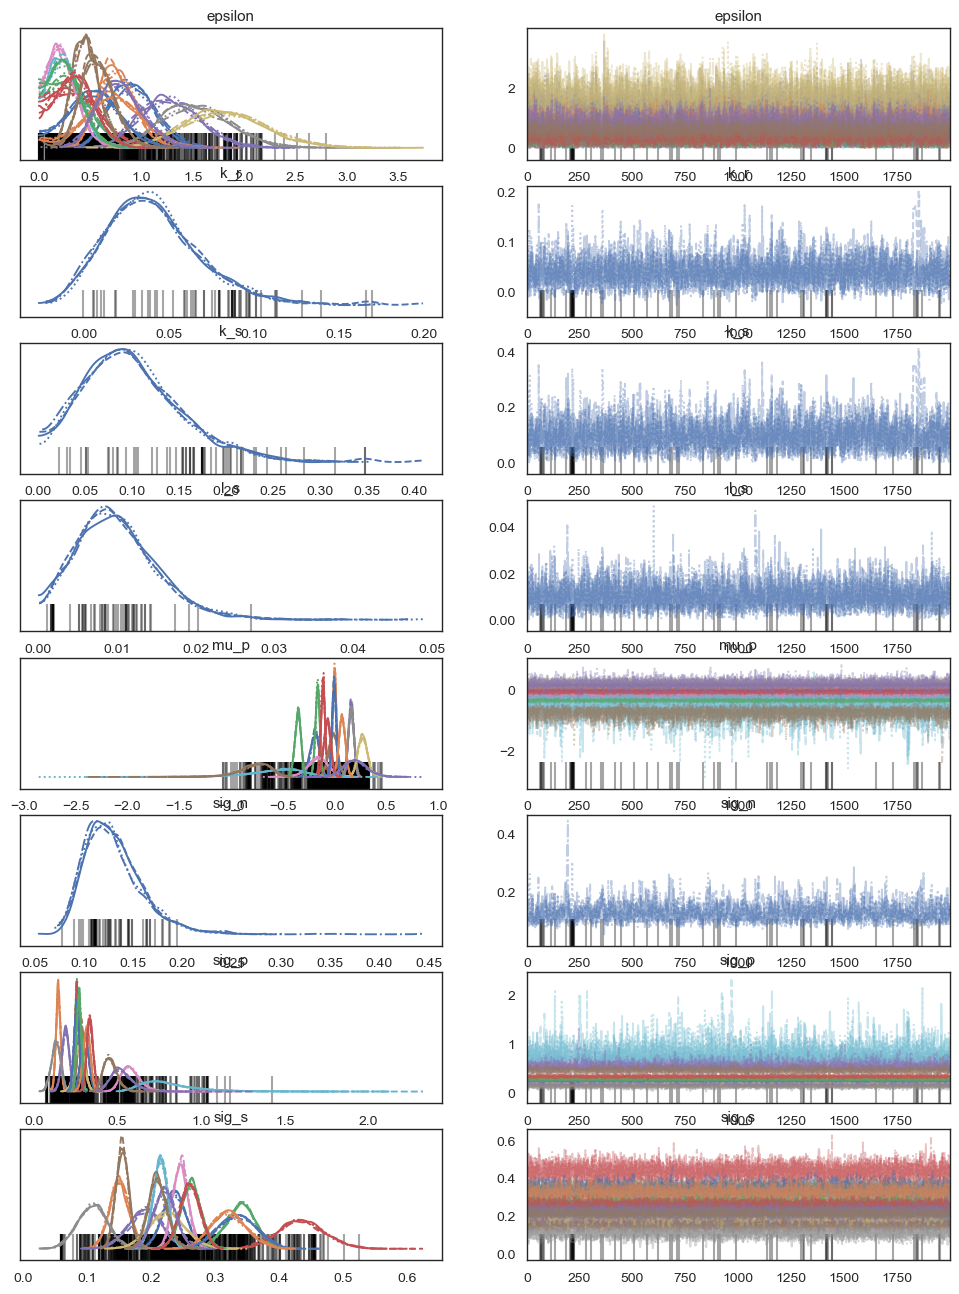

In [44]:
az.plot_trace(both_trace)

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


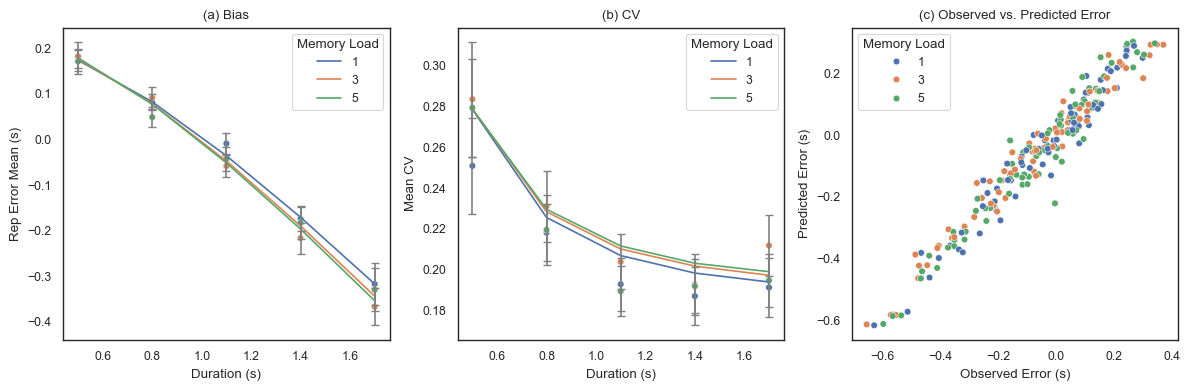

In [45]:
# plot the model prediction
plotModelPred(both_mdat, 'both')

Plot for four experiments together

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/473756658.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize', 'Exp.']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


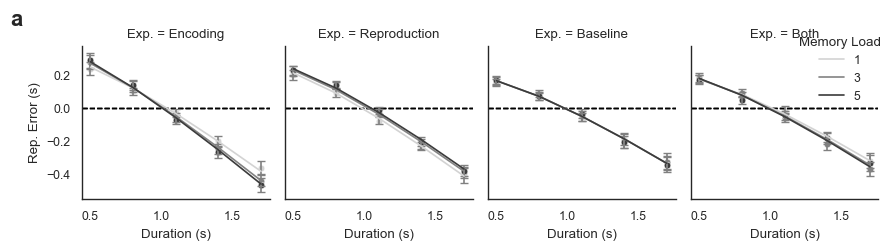

In [46]:
# combine encoding_mdat, reproduction_mdat, baseline_mdat, and both_mdat into mdat, but each data has additional column ExpName
encoding_mdat['Exp.'] = 'Encoding'
reproduction_mdat['Exp.'] = 'Reproduction'
baseline_mdat['Exp.'] = 'Baseline'
both_mdat['Exp.'] = 'Both'
exp_order = ['Encoding', 'Reproduction', 'Baseline', 'Both']
c_palette = ['lightgrey', '#838383',"#3b3b3b"] # consistent with R plot

mdat = pd.concat([encoding_mdat, reproduction_mdat, baseline_mdat, both_mdat], ignore_index=True)

# group and flatten the columns
mmdat = mdat.groupby(['curDur', 'WMSize', 'Exp.']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
									'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

# Create the FacetGrid, faceting on the ExpName column
g1 = sns.FacetGrid(mmdat, col="Exp.", hue="WMSize", height=2.5, aspect=0.8,col_order=exp_order, palette=c_palette)

# Map the scatter plot for reproduction error (repErr_mean)
g1.map(sns.scatterplot, 'curDur', 'repErr_mean')

# Add error bars to the scatter plots
def add_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=3, color='gray')

# Define a function to add the horizontal line at y=0
def add_hline(*args, **kwargs):
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Adds the horizontal line at y=0
# Add the horizontal line at y=0 to each subplot
g1.map(add_hline)

g1.map(add_error_bars, 'curDur', 'repErr_mean', 'repErr_sem')
# Map the line plot for predicted error (predErr_mean)
g1.map(sns.lineplot, 'curDur', 'predErr_mean')



# Customize the plot aesthetics
g1.set_axis_labels('Duration (s)', 'Rep. Error (s)')
# add legend on the top right corner
g1.add_legend(title='Memory Load')
# Adjust the legend position to the upper right corner of the entire plot
g1._legend.set_bbox_to_anchor((1, 0.9))  # Moves the legend to the upper right of the figure
g1._legend.set_loc('upper right')      # Aligns the legend to the upper right corner
# add label a to the top left corner of the first axis
g1.axes[0,0].text(0.01, 0.98, 'a', transform=g1.fig.transFigure, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
# save the figure to prediction_errors.png
plt.savefig(cpath + '/analysis/figures/prediction_errors.png')
# Show the plot

plt.show()

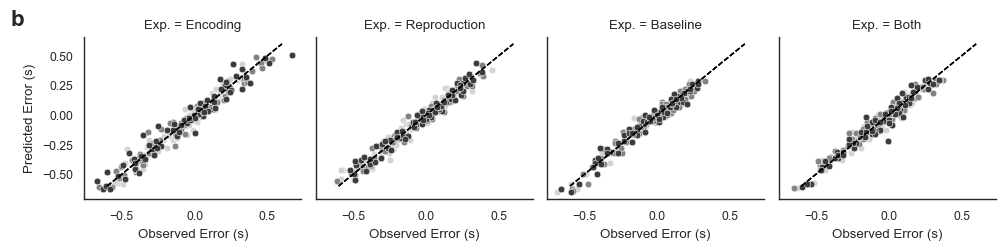

In [47]:

# Define a function to add the diagonal line
def add_diagonal(*args, **kwargs):
    ax = plt.gca()  # Get the current axis
    limits = [min(-0.6, -0.6), max(0.6, 0.6)]
    ax.plot(limits, limits, color='black', linestyle='--', linewidth=1)  # Draws the diagonal line

# now create the second pred. vs. obs. plot
# Create the FacetGrid, faceting on the ExpName column
g2 = sns.FacetGrid(mdat, col="Exp.", hue="WMSize", height=2.5, aspect=1,col_order=exp_order, palette=c_palette)
# Map the scatter plot for reproduction error (repErr_mean)
g2.map(sns.scatterplot, 'repErr', 'predErr')
# Add the diagonal line to each subplot
g2.map(add_diagonal)

# set x and y labels
g2.set_axis_labels('Observed Error (s)', 'Predicted Error (s)')
#g2.add_legend()
#g2._legend.set_title('Memory Load')
# add label a to the top left corner of the first axis
g2.axes[0,0].text(0.0, 0.98, 'b', transform=g2.fig.transFigure, fontsize=16, fontweight='bold', va='top')
# save the figure to predict_vs_obs.png
plt.savefig(cpath + '/analysis/figures/predict_vs_obs.png')


## Memory load with Gap on Encoding and Reproduction


In [48]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
dat_gap.head()

,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,WMRP,valid,stdRepDur,Exp,gap,log_RP,log_dur,Gap,ExpName
22963,3,2,2,1,1,0.8,1.245755,1,1,0.145447,Exp5,2,0.219742,-0.223144,2.5,Both_gap
22964,3,4,1,2,1,1.4,1.069342,2,1,0.200654,Exp5,2,0.067044,0.336472,2.5,Both_gap
22965,1,5,1,3,1,1.7,1.229175,1,1,0.219464,Exp5,2,0.206343,0.530628,2.5,Both_gap
22966,1,3,2,4,1,1.1,1.062077,1,1,0.158725,Exp5,2,0.060226,0.095310,2.5,Both_gap
22967,5,3,2,5,1,1.1,0.925818,2,1,0.146856,Exp5,2,-0.077078,0.095310,2.5,Both_gap


In [49]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
firstrun = False
if firstrun:
	constrain = [1,1,1,1] # scaling factor for k_s, l_s, gap, k_r
	both_gap_trace, both_gap_model, both_para, both_gap_mdat = runModel(dat_gap, constrain,'both_gap')
else:
	both_gap_trace = az.from_netcdf(cpath + '/data/both_gap_trace.nc')
	both_gap_mdat = pd.read_csv(cpath + '/data/both_gap_mdat.csv')
	both_gap_para = pd.read_csv(cpath + '/data/both_gap_para.csv')



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 507 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


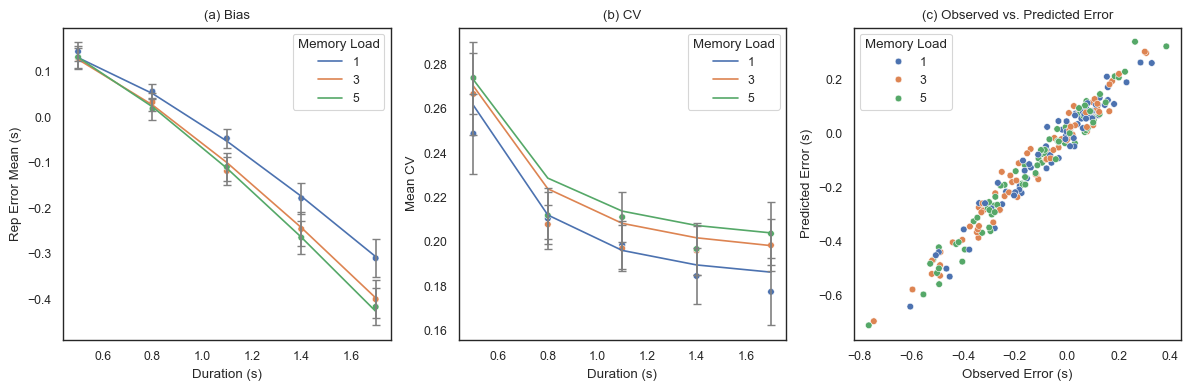

,NSub,curDur,WMSize,repDur_mean,repDur_std,mPred,sdPred,repErr,predErr,repCV,predCV
0,1,0.5,1,0.534481,0.111997,0.573391,0.096770,0.034481,0.073391,0.209543,0.168769
1,1,0.5,3,0.543289,0.099538,0.570775,0.097431,0.043289,0.070775,0.183213,0.170699
2,1,0.5,5,0.567658,0.106197,0.569674,0.097729,0.067658,0.069674,0.187080,0.171552
3,1,0.8,1,0.783153,0.125603,0.813505,0.135413,-0.016847,0.013505,0.160381,0.166457
4,1,0.8,3,0.878131,0.145447,0.806842,0.135902,0.078131,0.006842,0.165633,0.168438
...,...,...,...,...,...,...,...,...,...,...,...
220,15,1.4,3,1.142385,0.199044,1.115844,0.182132,-0.257615,-0.284156,0.174236,0.163224
221,15,1.4,5,1.122639,0.190813,1.107478,0.183793,-0.277361,-0.292522,0.169968,0.165956
222,15,1.7,1,1.195595,0.180776,1.247591,0.195936,-0.504405,-0.452409,0.151201,0.157052
223,15,1.7,3,1.211730,0.216265,1.210811,0.196294,-0.488270,-0.489189,0.178477,0.162118


In [52]:
# plot the model prediction
plotModelPred(both_gap_mdat, 'both_gap')
both_gap_mdat

# Within-subject Experiment 6


In [53]:
exp6.head()

,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,repWaitTime,WMRP,WMRTTest,valid,repBias,Exp
0,5,3,2,1,1,1.1,1.045568,1.765835,-1,2.000053,1,0.241000,Exp. 6a
1,5,4,1,2,1,1.4,1.149265,0.428690,1,0.911282,1,0.176418,Exp. 6a
2,5,3,1,3,1,1.1,1.173068,0.479047,1,0.842936,1,0.241000,Exp. 6a
3,1,1,2,4,1,0.5,1.005907,0.437188,1,0.731270,1,0.251074,Exp. 6a
4,1,2,1,5,1,0.8,0.797946,0.515922,1,0.888479,1,0.182591,Exp. 6a


In [54]:
# model for Exp. 6a, 6b, and 6c together
def wsModel(dat): #within-subject model
	# prepare the data
    subid = dat.NSub - 1 # starting from index 0
    nsub = len(dat.NSub.unique())  # number of subject
    # log-transformed working memory size
    wm_idx = np.log(dat.WMSize.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnDur = np.log(durs)

    # dummy variables for Exps. 
    dm_encoding = (dat.Exp == 'Exp. 6a').astype(int)
    dm_reproduction = (dat.Exp == 'Exp. 6b').astype(int)
    #dm_baseline = (dat.Exp == 'Exp. 6c').astype(int)

    niter = 1000
    # define model
    with pm.Model() as WMmodel:
        # sensory measurement
        sig_s = pm.HalfNormal('sig_s',1., shape = nsub) # noise of the sensory measurement
        # auxiliary variables (non-centered parameterization, individual level)
        epsilon = pm.HalfNormal('epsilon', 1, shape = nsub)
        k_s0 = pm.HalfNormal('k_s',1) # working memory coeff. on ticks
        k_s = epsilon * k_s0

        l_s0 = pm.HalfNormal('l_s',1) # working memory impacts on variance
        l_s = epsilon * l_s0
        wm_sig = np.log(dat.WMSize.to_numpy())
                  
        k_r0 = pm.Normal('k_r', 0, sigma = 1) # working memory influence on reproduction 
        k_r = epsilon * k_r0

        # prior (internal log encoding)
        mu_p = pm.Normal('mu_p', 0, sigma = 1, shape = nsub) # in log space
        sig_p = pm.HalfNormal('sig_p', 1, shape = nsub) # in log-space
        #mu_p = mu_p0 + sig_p[subid] * epsilon

        sig_n0 = pm.HalfNormal('sig_n', 1) #pm.Bound( pm.HalfNormal, lower = 0.15)('sig_n', 5.) # constant decision /motor noise
        sig_n = sig_n0 * epsilon
        # sensory measurement with log encoding + ticks loss by memory task
        D_s = lnDur - k_s[subid] * wm_idx * dm_encoding
        D_s = lnDur - k_s[subid] * wm_idx * dm_encoding

        sig_sm = sig_s[subid] + l_s[subid] * wm_sig * dm_encoding # variance influenced by memory tasks
        # integration with prior
        w_p = sig_sm*sig_sm / (sig_p[subid]*sig_p[subid] + sig_sm*sig_sm)
        # posterior
        u_x = (1-w_p)*D_s + w_p * mu_p[subid] # posterior mean
        sig_x2 = sig_sm*sig_sm*sig_p[subid]*sig_p[subid]/(sig_sm*sig_sm + sig_p[subid]*sig_p[subid])
        # reproduction
        # reproduced duration
        u_r = np.exp(u_x + k_r[subid] *dm_reproduction * wm_idx + sig_x2/2) # reproduced duration with corrupted from memory task
        #reproduced sigmas
        sig_r = np.sqrt((np.exp(sig_x2)-1)*np.exp(2*(u_x + k_r[subid] * dm_reproduction * wm_idx) +sig_x2 )  + 
            sig_n[subid]*sig_n[subid] /durs)

        # Data likelihood 
        resp_like = pm.Normal('resp_like', mu = u_r, sigma = sig_r, observed = repDur)

        trace = pm.sample(draws=2000, tune = 1000, progressbar=True, return_inferencedata=True, target_accept=0.85)
                  
    #step = pm.Metropolis() # Have a choice of samplers
    #trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    return  trace, WMmodel	


In [57]:
# run the model for Exp6
firstrun = False
if firstrun:
	exp6_trace, exp6_model = wsModel(exp6)
	with exp6_model:
		ppc = pm.sample_posterior_predictive(exp6_trace, var_names=['resp_like'])
		posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy() # back to linear scale
		posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2]) # reshape the array
	# get the mean of posterior samples
	exp6_mdat = getPosteriorSummary(posterior_samples, exp6)

	# summarize the trace
	exp6_para = az.summary(exp6_trace)
	# save the trace, model, mdat, and summary
	az.to_netcdf(exp6_trace, cpath + '/data/exp6_trace.nc')
	exp6_mdat.to_csv(cpath + '/data/exp6_mdat.csv')
	exp6_para.to_csv(cpath + '/data/exp6_para.csv')	
else:
	exp6_trace = az.from_netcdf(cpath + '/data/exp6_trace.nc')
	exp6_mdat = pd.read_csv(cpath + '/data/exp6_mdat.csv')
	exp6_para = pd.read_csv(cpath + '/data/exp6_para.csv')




/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1074998324.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


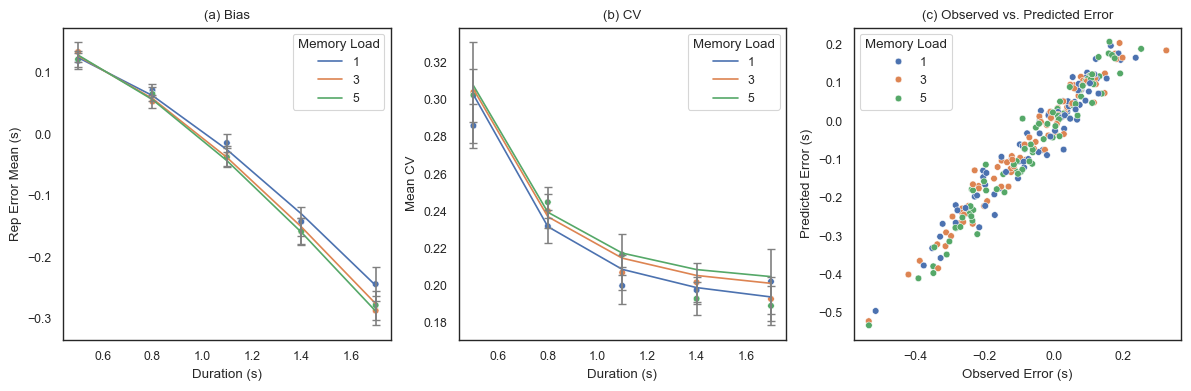

In [58]:
plotModelPred(exp6_mdat, 'exp6')

In [90]:
# model for Exp. 6a, 6b, and 6c separately, assuming without any knowledge
exp6a = exp6[exp6['Exp'] == 'Exp. 6a']
exp6b = exp6[exp6['Exp'] == 'Exp. 6b']
exp6c = exp6[exp6['Exp'] == 'Exp. 6c']

# run the model for Exp6a
constrain = [1,1,0,1] # scaling factor for k_s, l_s, gap, k_r
exp6a_trace, exp6a_model, exp6a_para, exp6a_mdat = runModel(exp6a, constrain, 'exp6a')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 176 seconds.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/4043399133.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/4043399133.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


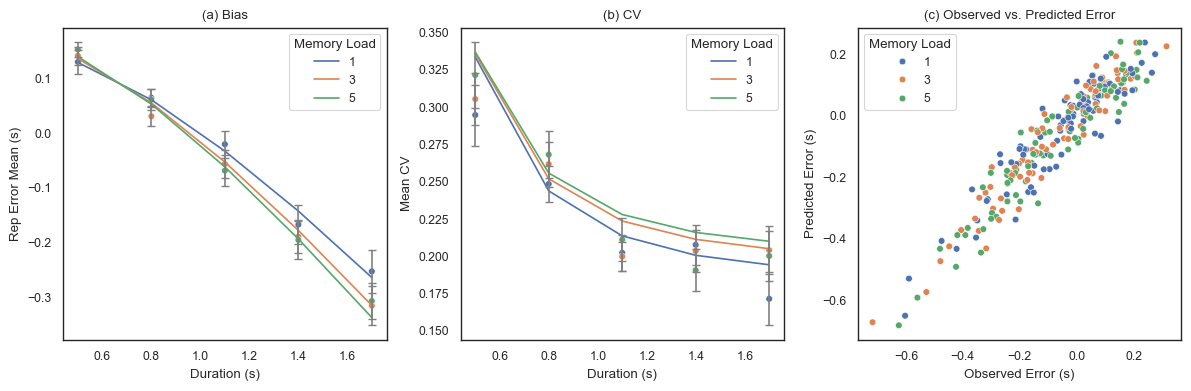

In [91]:
plotModelPred(exp6a_mdat, 'exp6a')

In [92]:
exp6b_trace, exp6b_model, exp6b_para, exp6b_mdat = runModel(exp6b, constrain, 'exp6b')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/4043399133.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


In [93]:
# same for exp6c
exp6c_trace, exp6c_model, exp6c_para, exp6c_mdat = runModel(exp6c, constrain, 'exp6c')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_s, epsilon, k_s, l_s, k_r, mu_p, sig_p, sig_n]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 310 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [resp_like]


Output()

/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/4043399133.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posterior_df = pd.concat([posterior_df, df], ignore_index = True)


In [94]:
def compute_subject_level_k_statistics(trace, k_param):
    """
    Computes the mean and standard deviation of k for each subject.

    Parameters:
    trace (arviz.InferenceData): The trace from the PyMC3 model, containing posterior samples.
    k_param (str): The name of the parameter (e.g., 'k_s', 'l_s', etc.).

    Returns:
    k_mean (np.ndarray): The mean of k for each subject.
    k_sd (np.ndarray): The standard deviation of k for each subject.
    """
    # Extract posterior samples for epsilon (shape: nchains, ndraws, nsub)
    epsilon_samples = trace.posterior['epsilon'].values  # epsilon for subjects

    # Extract posterior samples for the k parameter (shape: nchains, ndraws)
    k_samples = trace.posterior[k_param].values  # single value for k_param

    # Broadcast k_samples to match epsilon_samples' shape (nchains, ndraws, nsub)
    # We need to expand the dimension of k_samples to broadcast with epsilon_samples
    k_samples_expanded = np.expand_dims(k_samples, axis=-1)  # Add extra dimension

    # Element-wise multiplication to compute k for each subject (shape: nchains, ndraws, nsub)
    k_subject_samples = epsilon_samples * k_samples_expanded

    # Flatten the chains and draws to get all posterior samples of k for each subject
    k_subject_samples_flat = k_subject_samples.reshape(-1, k_subject_samples.shape[-1])  # (nchains*ndraws, nsub)

    # Calculate mean and standard deviation of k for each subject
    k_mean = np.mean(k_subject_samples_flat, axis=0)  # Mean for each subject
    k_sd = np.std(k_subject_samples_flat, axis=0)     # Standard deviation for each subject

    return k_mean, k_sd

# Example usage
# k_mean, k_sd = compute_subject_level_k_statistics(exp6_trace, 'k_s')
# for i, (mean, sd) in enumerate(zip(k_mean, k_sd)):
#     print(f"Subject {i+1}: Mean of k = {mean}, SD of k = {sd}")


In [95]:
#compute k statistics 
ks_exp6a, ks_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'k_s')
ks_exp6b, ks_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'k_s')
ks_exp6c, ks_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'k_s')
ls_exp6a, ls_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'l_s')
ls_exp6b, ls_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'l_s')
ls_exp6c, ls_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'l_s')
kr_exp6a, kr_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'k_r')
kr_exp6b, kr_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'k_r')
kr_exp6c, kr_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'k_r')
sn_exp6a, sn_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'sig_n')
sn_exp6b, sn_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'sig_n')
sn_exp6c, sn_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'sig_n')



In [114]:
# combine means together
para_exp6 = [ks_exp6a, ks_exp6b, ks_exp6c, ls_exp6a, ls_exp6b, ls_exp6c, 
			 kr_exp6a, kr_exp6b, kr_exp6c, sn_exp6a, sn_exp6b, sn_exp6c]
# reshape the array
para_exp6r = np.stack(para_exp6, axis=0).reshape(-1, 54).T

df_para_exp6 = pd.DataFrame(para_exp6r, columns = ['ks','ls','kr','sn'])
df_para_exp6['Experiment'] = ['Exp. 6a']*18 + ['Exp. 6b']*18 + ['Exp. 6c']*18
df_para_exp6['Subject'] = np.tile(np.arange(1,19), 3)
df_para_exp6.head()

,ks,ls,kr,sn,Experiment,Subject
0,0.018205,0.021842,-0.009797,0.146681,Exp. 6a,1
1,0.010112,0.012050,-0.005417,0.081289,Exp. 6a,2
2,0.010732,0.013044,-0.006009,0.087462,Exp. 6a,3
3,0.011981,0.014468,-0.006554,0.097285,Exp. 6a,4
4,0.014519,0.017475,-0.007855,0.117315,Exp. 6a,5


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1197509615.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'ks', ci = 'sd', ax = ax[0,0])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1197509615.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'ls', ci = 'sd', ax = ax[0,1])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1197509615.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'kr', ci = 'sd', ax = ax[1,0])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/1197509615.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para_exp6,

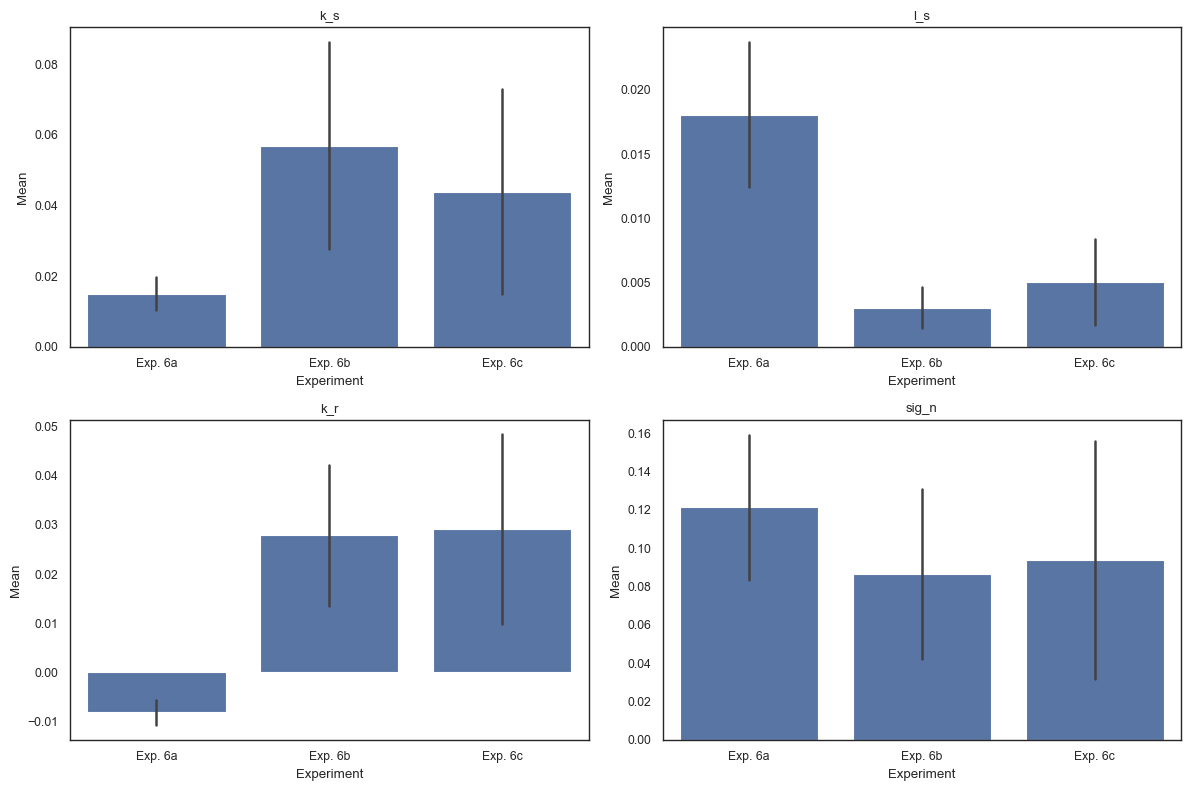

In [115]:
#plot mean and SEs of k_s, l_s, k_r, and sig_n as a function of Experiment
fig, ax = plt.subplots(2,2, figsize=(12, 8))
sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'ks', ci = 'sd', ax = ax[0,0])
ax[0,0].set_title('k_s')
ax[0,0].set_ylabel('Mean')
ax[0,0].set_xlabel('Experiment')
sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'ls', ci = 'sd', ax = ax[0,1])
ax[0,1].set_title('l_s')
ax[0,1].set_ylabel('Mean')
ax[0,1].set_xlabel('Experiment')
sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'kr', ci = 'sd', ax = ax[1,0])
ax[1,0].set_title('k_r')
ax[1,0].set_ylabel('Mean')
ax[1,0].set_xlabel('Experiment')
sns.barplot(data = df_para_exp6, x = 'Experiment', y = 'sn', ci = 'sd', ax = ax[1,1])
ax[1,1].set_title('sig_n')
ax[1,1].set_ylabel('Mean')
ax[1,1].set_xlabel('Experiment')
plt.tight_layout()
plt.savefig(cpath + '/analysis/figures/exp6_parameters.png')

Note: Visual differences, $l_s$ was higher for Exp. 6a than others, while $k_r$ was close to zero for Exp. 6a. 

In [116]:
ks_encoding, ks_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_s')
ls_encoding, ls_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'l_s')
kr_encoding, kr_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_r')
sn_encoding, sn_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'sig_n')

ks_reproduction, ks_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_s')
ls_reproduction, ls_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'l_s')
kr_reproduction, kr_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_r')
sn_reproduction, sn_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'sig_n')

ks_both, ks_both_sd = compute_subject_level_k_statistics(both_trace, 'k_s')
ls_both, ls_both_sd = compute_subject_level_k_statistics(both_trace, 'l_s')
kr_both, kr_both_sd = compute_subject_level_k_statistics(both_trace, 'k_r')
sn_both, sn_both_sd = compute_subject_level_k_statistics(both_trace, 'sig_n')

ks_both_gap, ks_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_s')
ls_both_gap, ls_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'l_s')
kr_both_gap, kr_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_r')
sn_both_gap, sn_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'sig_n')


In [117]:
# combine means together
para = [ks_encoding, ks_reproduction, ks_both, ks_both_gap, ls_encoding, ls_reproduction, ls_both, ls_both_gap, 
			 kr_encoding, kr_reproduction, kr_both, kr_both_gap, sn_encoding, sn_reproduction, sn_both, sn_both_gap]
# reshape the array, each array has (16,)
para_r = np.stack(para, axis=0).reshape(-1, 64).T
# create a dataframe
df_para = pd.DataFrame(para_r, columns = ['ks','ls','kr','sn'])
df_para['Experiment'] = ['Encoding']*16 + ['Reproduction']*16 + ['Both']*16 + ['Both_gap']*16
df_para.head()


,ks,ls,kr,sn,Experiment
0,0.098898,0.062314,0.020353,0.162367,Encoding
1,0.049785,0.031558,0.010258,0.082488,Encoding
2,0.055907,0.035491,0.011320,0.092197,Encoding
3,0.081117,0.051182,0.016613,0.133100,Encoding
4,0.045772,0.028545,0.009783,0.073572,Encoding


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/2118328285.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para, x = 'Experiment', y = 'ks', ci = 'sd', ax = ax[0,0])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/2118328285.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para, x = 'Experiment', y = 'ls', ci = 'sd', ax = ax[0,1])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/2118328285.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para, x = 'Experiment', y = 'kr', ci = 'sd', ax = ax[1,0])
/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_60193/2118328285.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data = df_para, x = 'Experiment', y

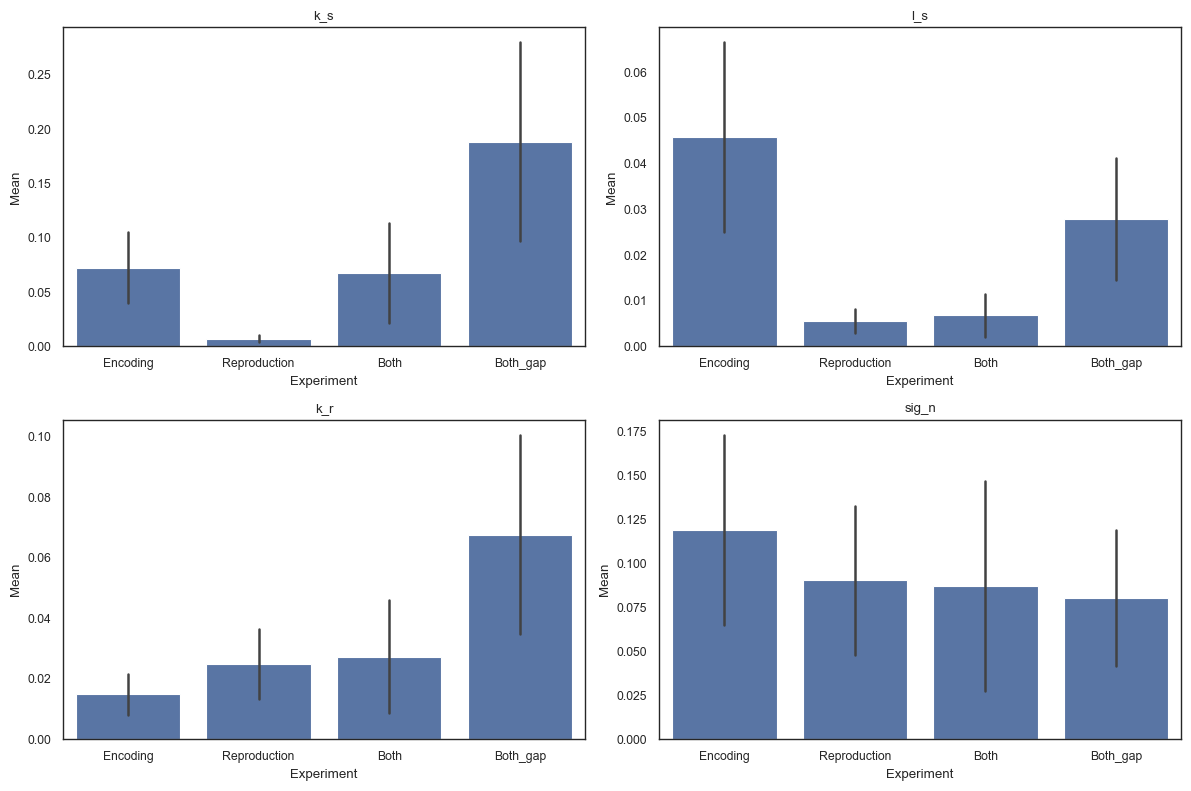

In [118]:
#plot mean and SEs of k_s, l_s, k_r, and sig_n as a function of Experiment
fig, ax = plt.subplots(2,2, figsize=(12, 8))
sns.barplot(data = df_para, x = 'Experiment', y = 'ks', ci = 'sd', ax = ax[0,0])
ax[0,0].set_title('k_s')
ax[0,0].set_ylabel('Mean')
ax[0,0].set_xlabel('Experiment')
sns.barplot(data = df_para, x = 'Experiment', y = 'ls', ci = 'sd', ax = ax[0,1])
ax[0,1].set_title('l_s')
ax[0,1].set_ylabel('Mean')
ax[0,1].set_xlabel('Experiment')
sns.barplot(data = df_para, x = 'Experiment', y = 'kr', ci = 'sd', ax = ax[1,0])
ax[1,0].set_title('k_r')
ax[1,0].set_ylabel('Mean')
ax[1,0].set_xlabel('Experiment')
sns.barplot(data = df_para, x = 'Experiment', y = 'sn', ci = 'sd', ax = ax[1,1])
ax[1,1].set_title('sig_n')
ax[1,1].set_ylabel('Mean')
ax[1,1].set_xlabel('Experiment')
plt.tight_layout()
#plt.savefig(cpath + '/analysis/figures/parameters.png')
